#**Final Project: ETF Price Forecasting Using BERT-Derived Sentiment Analysis of Stock-Related Tweets**

FRE-GY 7773: Machine Learning in Financial Engineering

Professor Sandeep Jain

Done by Sasha Agapiev (aba439) for 12/13/2022 

**ABSTRACT**

With the saturation of sophisticated mathematical models and automatized trading algorithms, modern traders are turning to non-quantitative methods to gain an intellectual edge over the competition. A popular qualitative method has been sentiment analysis (or "opinion mining"), which is the practice of using natural language processing (NLP) to categorize text into either positive (1), neutral (0), or negative (-1). Traders have applied sentiment analysis techniques to Twitter threads, Reuters comment sections, and Federal Reserve reports to quickly analyze sentiment and to profit on news reports by trading based on the detected sentiment. Logically, news reports which yield a positive sentiment translate to long positions in the respective stock/ETF and vice-versa. In this analysis, I have applied modern sentiment analysis strategies to Federal Reserve statements in a back-testing environment to test the effictiveneness of such a method when it comes to time series forecasting. 

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
**PART 1: Importing the BERT Model to Enable Sentiment Prediction**

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

*1.1: Importing relevant packages.*

In [1]:
!pip install transformers # The transformers package is required to run the BERT model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 12.1 MB/s 
     |████████████████████████████████| 7.6 MB 46.8 MB/s 
     |████████████████████████████████| 182 kB 47.7 MB/s 


In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import load_model
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

*1.2: Mounting Google Drive to Colab.*

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*1.3: Loading the trained BERT model by invoking TensorFlow's load_model().*

In [4]:
# Loading-in the Trained BERT model by calling load_weights
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
bert_model.load_weights('/content/drive/MyDrive/YEAR 4/ML/Assignments/FINAL PROJECT/BERT_Model_weights.h5') 
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

*1.4: Defining helper functions to generate predictions using the BERT model.*

In [5]:
# ~
# print_sentiment_predictions() is a helper function which takes two arguments:
#         sentences_to_predict: A list of strings (tweets) for which to calculate sentiment predictions
#         to_print: A boolean which we set to True if we want to print the prediction labels for each sentence
# If to_print is set to false, the function will return a list of 0s and 1s, 
# representing the sentiment predictions for each sentence in sentences_to_predict.
# The function works by applying a softmax layer to the BERT model. This softmax
# layer predicts an argmax of 0 if the sentiment for a given sentence is 
# determined to be negative, and 1 if it is determined to be positive.  
# ~
def get_sentiment_predictions(sentences_to_predict, to_print=False):
  max_len = 128       # The max acceptable length of a sentence in sentences_to_predict. Any input greater than this will cause the tokenizer to fail
  tf_batch = tokenizer(sentences_to_predict, max_length=max_len, padding=True, truncation=True, return_tensors='tf') # Tokenizing sentences_to_predict
  tf_outputs = bert_model(tf_batch) # Bert model's outputs, calculated using the tokenized input sentences
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1) # Applying the softmax layer to the Bert model's outputs
  labels = ['Negative','Positive'] # Labels for the softmax layer (0 is negative sentiment, 1 is positive)
  label = tf.argmax(tf_predictions, axis=1)  # Generating a list of labels using the softmax output
  label = label.numpy()                      # Converting the list of labels to a numpy array
  if to_print:                               # Check if we want to print the predictions, or return the list of labels
    for i in range(len(sentences_to_predict)):
      print(sentences_to_predict[i], ": \n", labels[label[i]])
  else:
    return label

*1.5: Testing if the sentiment prediction function works by running it on a list of fake tweets with varying sentiments.*

In [6]:
# test_pred_sentences are fake tweets that I made up to get a sense of how well
# the BERT model predicts sentiment. The first and third sentences both clearly
# exude positive sentiment, while the second sentence exudes negative sentiment.
test_pred_sentences = ['Super excited about this awesome stock, I know for a fact it will go up this week!',
                  'Horrible, terrible investment choice, would be better off buying an NFT', 
                  'Oh my god, Gamestop is doing so well right now I cant wait to invest more',]

In [7]:
# Call get_sentiment_predictions with print mode turned on to see if the model
# works as expected
get_sentiment_predictions(test_pred_sentences, to_print=True)

Super excited about this awesome stock, I know for a fact it will go up this week! : 
 Positive
Horrible, terrible investment choice, would be better off buying an NFT : 
 Negative
Oh my god, Gamestop is doing so well right now I cant wait to invest more : 
 Positive


Thankfully, the BERT model labels these test sentences as we would expect it to. We can also see how these predictions correspond to the list of labels generated by the softmax layer by calling get_sentiment_predictions
with print mode turned off:

In [8]:
get_sentiment_predictions(test_pred_sentences, to_print=False)

array([1, 0, 1])

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
**PART 2: Importing Dataset of 7 million Stock-Related Tweets (tweeted from May 2018 to September 2018)**

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

*2.1: Defining a helper function to import tweets from the data set.*

In [9]:
# ~
# import_tweet_dataset() is a helper function which takes one argument:
#         already_created: Has this dataframe already been created
# Creating the dataframe directly from the tweet data set csv file takes
# a very long time, and to avoid having to do this every time we run the 
# notebook we can choose to read import tweets_df from Google Drive by 
# setting already_created to True. If we set already_created to False, 
# then we are starting this process over from scratch (which takes much 
# longer).
# ~
def import_tweet_dataset(already_created=True):
  if already_created:
    tweets_df = pd.read_csv('/content/drive/MyDrive/YEAR 4/ML/Assignments/FINAL PROJECT/tweets_df.csv')
    tweets_df.set_index("Date", inplace=True)
    return tweets_df 
  else:
    # Using Pandas read_csv() to create a Dataframe of tweets
    tweets_df = pd.read_csv('/content/drive/MyDrive/YEAR 4/ML/Assignments/FINAL PROJECT/tweets.csv', on_bad_lines="skip")
    # Dropping irrelevant columns
    tweets_df.drop(['id', 'user_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_user_id', 'source'], axis=1, inplace=True)
    # Dropping tweets that are not labelled as English because our BERT model is not trained to understand these
    tweets_df = tweets_df.loc[tweets_df['lang'] == 'en'] 
    tweets_df.drop(['lang'], axis=1, inplace=True)
    # Parsing "created_at dates into Datetime format and set them as the DataFrame's index to help with SPY forecasting
    tweets_df['Date'] = pd.to_datetime(tweets_df['created_at']).dt.strftime('%Y-%m-%d') # Only interested in the year, month, and day of tweets' creation dates
    # Setting tweet dates to act as the index for the Dataframe for when we apply the trading strategy
    tweets_df.set_index("Date", inplace=True)
    # Dropping the full creation time column since we no longer need this
    tweets_df.drop(['created_at'], axis=1, inplace=True)
    # Dropping duplicate and NaN values
    tweets_df = tweets_df.drop_duplicates()
    tweets_df = tweets_df.dropna()
    # Saving tweets_df to disk/Drive so we can call import_tweet_dataset(already_created=True) next time we run the notebook
    # tweets_df will be saved to disk as 'tweets_df.csv' 
    tweets_df.to_csv('tweets_df.csv', encoding='utf-8')
    return tweets_df

*2.2: Calling the helper function based on whether we want to create the Dataframe from scratch, or import it from Disk/Drive.*

In [10]:
# tweets_df = import_tweet_dataset(already_created=False)
tweets_df = import_tweet_dataset(already_created=True)

*2.3: Getting a sense of the tweets in the Dataframe by calling df['text'].describe().*

In [11]:
tweets_df['text'].describe()

count                                               6470557
unique                                              6470557
top       RT @cruzfloresiv: To all the weak hands who so...
freq                                                      1
Name: text, dtype: object

*2.4: Displaying the first and last 10 rows for unsupervised analysis.*

In [12]:
tweets_df.head(10)

,text
Date,
2017-05-18,RT @cruzfloresiv: To all the weak hands who so...
2017-05-18,"Investors Eye Fed, But Bond ETFs Still Add Ass..."
2017-05-18,Sell $NLNK (Ne❑wLink Genetics Corporation) tha...
2017-05-18,Increase: $VCO $NTES $BPT $ENIC $QIWI $JP $STX...
2017-05-18,"Former #FDA commissioner Califf joins Verily, ..."
2017-05-18,https://t.co/uy1J6ORiZ6 $140 loss $TYHT See my...
2017-05-18,"https://t.co/WgmfPFMVff $5,348 loss $PULM See ..."
2017-05-18,RT @djdsk3000: $ltc it's about that time #LTC
2017-05-18,EA's Success This Year Is Contingent On Star W...


In [13]:
tweets_df.tail(10)

,text
Date,
2017-09-12,This guy is awesome @julianhosp #tenx $pay htt...
2017-09-12,RT @VIX_Strategies: 5 Key Characteristics for ...
2017-09-12,Didn't think it would work but I got +80% in 1...
2017-09-12,$AAPL Can do this for a while w/o need for rei...
2017-09-12,The New #Apple Watch Is Basically Also a Smart...
2017-09-12,The #iPhone Forever Changed Our Lives $AAPL ht...
2017-09-12,"#Apple Watch Series 3 is here, LTE, barometric..."
2017-09-12,"NRG Energy, Inc. $NRG Receives $21.13 Average ..."
2017-09-12,Reviewing Arch Therapeutics $ARTH and Globus M...


*2.5: Finally, we should test the sentiment predict functionality on some of the tweets.*

In [14]:
#~
# get_tweets_by_date() is a helper function which takes a datetime input
# and returns a numpy array of all tweets in the tweet dataframe which were 
# posted on this date.
#~
import re
def get_tweets_by_date(datetime):
  tweets_unparsed = tweets_df.loc[datetime].to_numpy() # Get a numpy array of all the tweets from this date
  tweets_parsed = []
  for t in tweets_unparsed:
    unparsed_text = t[0]
    parsed_text1 = re.sub(r'http\S+', '', unparsed_text) # Removing URLs from tweets
    parsed_text = re.sub('@[^\s]+','', parsed_text1) # Removing usernames and mentions from tweets
    parsed_trimmed_text = (parsed_text[:128] + '') if len(parsed_text) > 128 else parsed_text # Only keep tweets with length <= 128 characters to avoid spam
    tweets_parsed.append(parsed_trimmed_text)
  return tweets_parsed

In [15]:
# Test the sentiment prediction on the first 10 tweets from September 12, 2017
test_arr = get_tweets_by_date('2017-09-12')
test_arr = test_arr[:10]
get_sentiment_predictions(test_arr, to_print=True)

#BTC price decreased! Buying @ $4204.05 &amp; Selling @ $4207.13  $btc $eth $etc $neo $dgb $dash $strat $eos $omg $pay $xrp $xmr : 
 Negative
Feds To Partially Blame Tesla's Autopilot In Fatal Crash: Report $TSLA  : 
 Negative
Risk on time.  Look out below in $GLD $TLT $VIX  : 
 Negative
#Ethereum #price: 296.00$. Low: 287.54$  High: 307.93$. Trade   $eth #cryptocurrency : 
 Positive
$F is active on the market, #trading at $11.41 (+0.44%)  Check out our #sentiment analysis tool free:  #investing : 
 Positive
#ElectronicArts Unity CEO John Riccitiello on Apple's big event, privacy and the AR apps we'l... Read more:  $EA : 
 Positive
#Snapchat Maps Gives Us Firsthand Look at How Bad Hurricane Irma Really Is. Read more:  $SNAP : 
 Positive
#Equifax Hack Teaches Hard Lessons About Data Regulation and Incident Response. Read more:  $EFX : 
 Negative
NY Times says #Amazon should build in CO. Read more:  $AMZN : 
 Positive
#Boeing Names Phil Musser to Top Communications Post. Read more:  $BA 

In [16]:
get_sentiment_predictions(test_arr, to_print=False) 

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1])

As we can see from the test code above, our BERT model can succesfully predict the sentiment of a given array of tweets! Although it is impossible to quantitatively prove whether these sentiment predictions are correct since the dataset is not labelled, we can logically see that most of the predictions make sense. 

For instance, **"NY Times says #Amazon should build in CO"** is most likely a positive tweet since the NYT is implying that Amazon will expand to a new state which should lead to an increase in sales, and **"Feds To Partially Blame Tesla's Autopilot In Fatal Crash: Report $TSLA"** would probably qualify as negative news for Tesla for obvious reasons.

Nevertheless, there will always be some results that seem off, but this is to be expected since our BERT model only had 83.5% validation accuracy on StockTwits data. 

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~  

**PART 3: Applying a Sentiment-Based ETF Forecasting Strategy for SPY and DJIA**

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

*3.1: We first need to import SPY and DJIA price data into a single Pandas dataframe.*

In [17]:
# ~
# read_data() is a helper function that takes a ticker name as its only argument, 
# then reads in this ticker's data from Google Drive and returns a pandas dataframe
# ~
def read_data(ticker):
  path = '/content/drive/MyDrive/YEAR 4/ML/Assignments/FINAL PROJECT/' + ticker + '.csv'
  data = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
  return data

In [18]:
# ~
# import_ETF_data() is a helper function that calls read_data to 
# retrieve SPY and DJIA price data from a CSV file and loads it 
# into a Pandas DataFrame. Then, the function uses this price
# DataFrame to create a daily returns DataFrame for SPY and DJIA
# daily prices. The function returns the two DataFrames, ETF_prices
# and ETF_returns.
# ~

def import_ETF_data():
  SPY_data = read_data("SPY_price_data")
  DJIA_data = read_data("DJIA_price_data")
  ETF_prices = SPY_data.drop(['PX_VOLUME'], axis=1)
  ETF_prices["DJIA Prices"] = DJIA_data['PX_LAST']
  ETF_prices.rename(columns={'PX_LAST':'SPY Prices'}, inplace=True)
  ETF_prices = ETF_prices.loc["2017-05-14":"2017-09-17", :]
  ETF_returns = pd.DataFrame(data=np.zeros(shape=(len(ETF_prices.index), ETF_prices.shape[1])), 
                              columns=ETF_prices.columns.values,
                              index=ETF_prices.index)
  for col in ETF_returns.columns:
    ETF_returns[col] = ETF_prices[col].pct_change()
  ETF_returns = ETF_returns.dropna()
  ETF_returns.rename(columns={"SPY Prices": "SPY Returns", "DJIA Prices" : "DJIA Returns"}, inplace=True)
  return ETF_prices, ETF_returns

In [19]:
ETF_prices, ETF_returns = import_ETF_data()

*3.2: Testing if the data imported correctly by displaying the first and last 5 rows of ETF_prices and ETF_returns.*

In [20]:
ETF_prices.head(5)

,SPY Prices,DJIA Prices
Date,,
2017-05-15,240.30,209.93
2017-05-16,240.08,209.95
2017-05-17,235.82,206.47
2017-05-18,236.77,206.96
2017-05-19,238.31,207.77


In [21]:
ETF_prices.tail(5)

,SPY Prices,DJIA Prices
Date,,
2017-09-11,249.21,220.76
2017-09-12,250.05,221.42
2017-09-13,250.17,221.76
2017-09-14,250.09,222.32
2017-09-15,249.19,222.45


In [22]:
ETF_returns.head(5)

,SPY Returns,DJIA Returns
Date,,
2017-05-16,-0.000916,0.000095
2017-05-17,-0.017744,-0.016575
2017-05-18,0.004028,0.002373
2017-05-19,0.006504,0.003914
2017-05-22,0.005077,0.004235


In [23]:
ETF_returns.tail(5)

,SPY Returns,DJIA Returns
Date,,
2017-09-11,0.010666,0.011547
2017-09-12,0.003371,0.002990
2017-09-13,0.000480,0.001536
2017-09-14,-0.000320,0.002525
2017-09-15,-0.003599,0.000585


*3.4: With our data correctly stored in a Dataframe, we can define the helper function which will power our trading strategy.*

In [24]:
# ~
# are_tweets_positive() is a helper function which calculates whether the 
# tweets on a given day more positive than negative. It takes the following
# arguments:
#         datetime: The date we want to get a sentiment signal for 
#         threshold_ratio: The ratio of positive to negative tweets which needs to be exceeded in order to get a positive sentiment signal
#         cutoff_ratio: The percentage of tweets we want to analyze for the day (1 = all the tweets tweeted on the given day, 0.5 = half, etc...)
#         debugging: A boolean which we set to True if we want to see helpful print statements
#         return_ratio: A boolean which we set to True if we want the function to return the positive to negative ratio itself, rather than a signal
# The function will return a trading signal depending on these arguments.
# For example, if we call are_tweets_positive('2017-09-12', 0.8, 0.5), the 
# function will return True if more than 80% of tweets on 2017-09-12 are positive 
# and false otherwise, using only 50% of tweets for that day to get the calculation.
# If we want to get the positive to negative ratio as a number, set return_ratio
# equal to True.
# The reason why we use cutoff_ratio is because there are ~70,000 stock-related 
# tweets posted every day, so we can choose to omit some of them to speed-up 
# the computation.
# For increased speed, turn on Colab GPU optimization in Notebook settings. 
# ~
def are_tweets_positive(datetime, threshold_ratio=0.5, cutoff_ratio=0.1, debugging=False, return_ratio=False):
  tweets_pre = get_tweets_by_date(datetime)   # Get the data set of tweets for the given datetime
  tweets = np.asarray(tweets_pre)             # Convert the data set into numpy array so we can use np.array_split
  chunk_size = len(tweets) / 100              # Split the data set of daily tweets into "chunks" of 100 tweets
  chunks = np.array_split(tweets, chunk_size) # This is because we can only predict lists of 100 at a time or else Colab runs out of RAM
  cutoff_amount = int(cutoff_ratio * len(chunks)) # If cutoff_ratio is 1 (100%), then we use the whole dataset for the day.
  positive_count = 0                          # Total number of tweets labelled as positive
  total_count = 0                             # Total number of tweets seen
  num_iters = 0                               # Number of chunks predicted so far (used for debugging)
  for chunk in chunks[:cutoff_amount]:        # Iterate through each chunk (if cutoff_ratio=1, then we predict every chunk for the day)
    if debugging:                             # Only print status if debugging is set to True
      if num_iters % 5 == 0:
        print("CHUNKS PROCESSED: ", num_iters)
    num_iters += 1
    flat_chunk = chunk.tolist()               # Turn the chunk into a list so we can apply softmax to it and get a prediction
    chunk_predictions = get_sentiment_predictions(flat_chunk) 
    for p in chunk_predictions:               # chunk_predictions is just a list of 1s (positive sentiment tweets) and 0s (negative sentiment tweets)
      if p == 1:          
        positive_count += 1
      total_count += 1
  positive_ratio = positive_count / total_count # The "positive tweet ratio" is just the proportion of tweets in a day that are positive
  if debugging:
    print("POSITIVE RATIO: ", positive_ratio)
  if return_ratio:                              # If return_ratio is set to True, then we return positive_ratio as a number
    return positive_ratio 
  if positive_ratio > threshold_ratio:          # Else, we return True is positive_ratio > threshold_ratio and False otherwise
    return True
  else:
    return False

*3.5: Testing the functionality of are_tweets_positive on a highly-reduced daily tweet dataset and with debugging functionality turned on to get a sense of performance.*

In [25]:
# ~
# Using a cutoff_ratio of 0.1 means we are getting the positive tweet ratio using only 10% of the dataset
# for the given day (2017-09-12). Using a threshold ratio of 0.5 means we get a positive signal if 
# the positive ratio for the day is greater than 50%. Setting debugging to True just means we are
# printing the outputs to get a sense of performance
# ~
pos = are_tweets_positive('2017-09-12', threshold_ratio=0.5, cutoff_ratio=0.1, debugging=True)
if pos:
  print("The tweets on 2017-09-12 give a positive trading signal!")
else:
  print("The tweets on 2017-09-12 give a negative trading signal :(")

CHUNKS PROCESSED:  0
CHUNKS PROCESSED:  5
CHUNKS PROCESSED:  10
CHUNKS PROCESSED:  15
CHUNKS PROCESSED:  20
CHUNKS PROCESSED:  25
CHUNKS PROCESSED:  30
CHUNKS PROCESSED:  35
CHUNKS PROCESSED:  40
CHUNKS PROCESSED:  45
CHUNKS PROCESSED:  50
CHUNKS PROCESSED:  55
CHUNKS PROCESSED:  60
CHUNKS PROCESSED:  65
POSITIVE RATIO:  0.8155586987270156
The tweets on 2017-09-12 give a positive trading signal!


*3.6: Graphically visualizing how different cutoff ratios affect the difference between the true positive ratio for a day (i.e: the positive ratio we get when using a cutoff ratio of 1, meaning we use the entire tweet data set of ~70,000 tweets for the day) and the positive ratio on the reduced data set.*

In [26]:
import matplotlib.pyplot as plt
cutoffs = [0.05, 0.1, 0.25, 0.5, 0.75, 0.8, 0.9]
cutoffs_to_plot = [100*c for c in cutoffs] # We want to plot the cutoffs as percentages

# ~
# test_cutoff_performance() is a helper function that takes two arguments:
#       cutoffs: A list of cutoffs (0 < cutoff <= 1) representing the cutoff ratios that we would like to test 
#       datetime: The day we want to perform the test on
# The function has no return values, but instead it just plots a graph of positive ratios vs cutoffs for the day, 
# and compares this with the true positive ratio. We use this function to graphically visualize how different 
# cutoff ratios affect the difference between the true positive ratio and the positive ratio given by data sets
# of variangly-reduced sizes.
# ~
def test_cutoff_performance(cutoffs, datetime):
  positive_ratios = []
  true_ratio = are_tweets_positive(datetime, cutoff_ratio=1, return_ratio=True)  # The positive_ratio we get when we use all tweets for the day (full dataset)
  true_ratio_list = [true_ratio] * len(cutoffs) # As a constant list (for plotting)
  for c in cutoffs:
    pos_ratio = are_tweets_positive(datetime, cutoff_ratio=c, return_ratio=True) # Calculate the positive ratio for each cutoff ratio in cutoffs
    positive_ratios.append(pos_ratio) # And we add this to the list of positive ratios
  plt.rcParams["figure.figsize"] = [7.00, 3.50] # Create a plot to display the results
  plt.rcParams["figure.autolayout"] = True
  plt.plot(cutoffs_to_plot, positive_ratios, c='g', label="Positive Ratio")
  plt.plot(cutoffs_to_plot, true_ratio_list, c='purple', label="Positive Ratio When Using Full Data Set")
  titlestr = "Positive Ratio of Tweets on " + datetime + " When Using Varying Dataset Cutoffs" 
  plt.title(titlestr)
  plt.xlabel("Cutoff (Percent of Daily Tweet Data Set Used)")
  plt.ylabel("Positive Ratio of Tweets")
  plt.legend(loc="best")
  plt.show()

In [ ]:
# We want to test how the cutoff ratios play a role on five different days

#test_cutoff_performance(cutoffs, '2017-09-12')
#test_cutoff_performance(cutoffs, '2017-09-11')
#test_cutoff_performance(cutoffs, '2017-09-10')
#test_cutoff_performance(cutoffs, '2017-09-09')
#test_cutoff_performance(cutoffs, '2017-09-08')

*3.7: We see that cutoff ratio affects the accuracy of the positive ratio, but to a very minimal extent. This means there is no point in using the whole tweet dataset for each day to get our trading signals since this takes a huge amount of time computationally with little added benefit. Thus, we will use a cutoff ratio of 0.5 when calculating the trading signals in the next step, and we will store these trading signals to disk so we don't have to compute them more than once.*

In [27]:
# ~
# get_sentiment_trading_signals() is a helper function that takes two arguments:
#         cutoff: The data cutoff ratio (percentage) to be used when calculating the positive ratio of tweets for a day
#         lookback_amount: How far to lookback when getting a sentiment calculation for a trading day
# The function will return a list of positive_ratios for all the days in the
# ETF_prices DataFrame, using the lookback_amount. 
# For instance, using a lookback_amount of 1 would mean that for a given trading 
# day d, we calculate the sentiment trading signal for this day by calling 
# are_tweets_positive on the tweet data set for d-1 (i.e: 1 day prior). If 
# lookback_amount is set to 7, then we get the sentiment trading signal for 
# the day by analyzing the sentiment of tweets from one week prior. 
# In our trading strategy, we use a lookback_amount of 1 because tweets are 
# very reactive and so they reflect current trends well, and also because 
# a lookback_amount of 1 day is common in papers that discuss Twitter sentiment
# analysis for trading strategies. 
# ~
from datetime import datetime, timedelta
def get_sentiment_trading_signals(cutoff, lookback_amount):
  signals = []
  for date in ETF_prices.index[5:-5].strftime('%Y-%m-%d'):
    previous_day = datetime.strptime(date, '%Y-%m-%d') - timedelta(days=lookback_amount) # Get the previous day
    previous_day = previous_day.strftime('%Y-%m-%d') # Convert previous_day to datetime string
    signal = are_tweets_positive(previous_day, cutoff_ratio=cutoff, return_ratio=True)
    signals.append(signal)
  return signals

# ~
# create_signals_list() is a helper function that calls get_sentiment_trading_signals
# to get a list of sentiment signals if already_created==False, and then saves
# this list to disk. If already_created == True, then the function simply
# creates the list by reading input from the file on disk. This is to save
# time and computational resources since creating the signals list 
# takes over 1 hour. 
# ~
def create_signals_list(cutoff=0.5, lookback_amount=1, already_created=True):
  if already_created:
    signals = []
    f = open('sentiment_list.txt', 'r')
    print(f.read())
    f.close()
    return(signals)
  else:
    signals = get_sentiment_trading_signals(cutoff, lookback_amount)
    with open('sentiment_list.txt', 'w+') as f:
      for signal in signals:
        f.write('%d' %signal)
    print("File written successfully")
    f.close()
    return(signals)

In [ ]:
signals = get_sentiment_trading_signals(0.5, 1)
print(signals)
# create_signals_list(already_created=False)

*3.8: With the sentiment trading signals calculated, let us do some unsupervised analysis to see how these signals correlate with actual ETF prices and returns.*

In [ ]:
# ~
# pos_ratio_vs_day() is a helper function that takes a list of sentiment
# signals and plots them against ETF prices and returns. This is helpful
# for unsupervised analysis of how tweet sentiment correlates to ETF 
# behavior
# ~
def pos_ratio_vs_day(signals): 
  dates = []
  positive_ratios_100 = []
  positive_ratios = []
  for date in ETF_prices.index[5:75].strftime('%Y-%m-%d'):
    dates.append(date)
    positive_ratio = signals[0]
    positive_ratios_100.append((positive_ratio*100))
    positive_ratios.append(positive_ratio)
  SPY_prices = ETF_prices[5:75]["SPY Prices"].values
  SPY_returns = ETF_returns[5:75]["SPY Returns"].values
  DJIA_prices = ETF_prices[5:75]["DJIA Prices"].values
  DJIA_returns = ETF_returns[5:75]["DJIA Returns"].values
  DJIA_returns = DJIA_returns*100 
  SPY_returns = SPY_returns*100
  fig, ax = plt.subplots(1, 2, figsize=(18,6))
  ax[0].plot(dates, positive_ratios_100, c="g", label="Positive Sentiment Ratio (%)")
  ax[0].plot(dates, SPY_prices, c="r", label="SPY Price")
  ax[0].set_title("Positive Sentiment Ratios and SPY Prices Over 2 Trading Month Period", weight="bold")
  ax[0].legend(loc="best")
  ax[1].plot(dates, positive_ratios_100, c="g", label="Positive Sentiment Ratio (%)")
  ax[1].plot(dates, DJIA_prices, c="b", label="DJIA Price")
  fig.autofmt_xdate(rotation=60)
  fig.tight_layout()
  ax[1].set_title("Positive Sentiment Ratios and DJIA Prices Over 2 Trading Month Period", weight="bold")
  ax[1].legend(loc='best')
  fig.show()
  fig, ax = plt.subplots(1, 2, figsize=(18,6))
  ax[0].plot(dates, positive_ratios, c="g", label="Positive Sentiment Ratio")
  ax[0].plot(dates, SPY_returns, c="r", label="SPY Returns (*100)")
  ax[0].set_title("Positive Sentiment Ratios and SPY Returns Over 2 Trading-Month Period", weight="bold")
  ax[0].legend(loc="best")
  ax[1].plot(dates, positive_ratios, c="g", label="Positive Sentiment Ratio")
  ax[1].plot(dates, DJIA_returns, c="b", label="DJIA Returns (*100)")
  fig.autofmt_xdate(rotation=60)
  fig.tight_layout()
  ax[1].set_title("Positive Sentiment Ratios and DJIA Returns Over 2 Trading-Month Period", weight="bold")
  ax[1].legend(loc='best')
  fig.show()

In [ ]:
pos_ratio_vs_day(signals)

This graph shows that the great majority of tweets are postive. This does mean the BERT sentiment prediction model is broken, but instead implies that most stock-related tweets express positive sentiment. In essence, this makes sense since most people would only publicly broadcast their trading performance if they were doing well.

*3.9: Now, we can finally define our sentiment trading strategy. The strategy works by following the logic given by this pseudocode:*

**For every day in our ETF price dataset, check the sentiment trading signal for this day (using the signals calculated earlier).** 

**If the sentiment signal > pos_threshold, go long k units of the ETF.**

**Else if the sentiment signal < neg_threshold, sell k units of the ETF.** 

**Else, hold the current position.**

**For every position taken, use the value of this position to update the portfolio value which starts at initial_portfolio_value.**

In [ ]:
# ~
# sentiment_trading_strategy() is the main function for this notebook. It takes 
# the following arguments:
#         initial_portfolio_value
#
#
#
# ~If tweets for one day are majority positive go long 1 SPY and 1 DJIA, else sell k SPY and k DJIA
def sentiment_trading_strategy(initial_portfolio_value, signals, k, ETF, pos_threshold, neg_threshold):
  ETF = ETF + " Prices"
  portfolio = []
  prev_gain = initial_portfolio_value
  portfolio.append(initial_portfolio_value) # We start by going long k units for the ETF
  signals_indx = 0
  indicators = []
  for date in ETF_prices.index[5:-5].strftime('%Y-%m-%d'):
    todays_price = ETF_prices.loc[date][ETF] # Get today's price 
    signal = signals[signals_indx]
    if signal > pos_threshold:   # If the trading signal on the previous day is positive, then we go long k units of the ETF
      indicators.append(1)
      portfolio_value_change = k*todays_price 
      portfolio_value_gain = prev_gain + portfolio_value_change
      portfolio.append(portfolio_value_gain) # Add the portfolio value gain to the portfolio
    elif signal < neg_threshold:
      indicators.append(-1)
      portfolio_value_change = -(k*todays_price)
      portfolio_value_gain = prev_gain + portfolio_value_change
      portfolio.append(portfolio_value_gain)
    else:
      indicators.append(0)
      portfolio.append(prev_gain)
    prev_gain = portfolio_value_gain
    signals_indx += 1
  return portfolio, indicators

*3.10: We have now successfully implemented our sentiment-based ETF trading strategy! All that remains is to now optimize and analyze the performance of this strategy by finding which positive-negative threshold combination yields the most accurate indicators, and then we will use this combination for model performance analysis in Section 4. We will find the optimal positive-negative threshold combination using the get_optimal_pos_neg_thresholds() helper function.*

In [ ]:
# ~
#
#
# ~
def signal_accuracy(indicators, returns):
  correct_num = 0
  total_num = 0
  for i in range(len(indicators)):
    if indicators[i] == 1:
      total_num += 1
      if returns[i] > 0:
        correct_num += 1
    elif indicators[i] == -1:
      total_num += 1
      if returns[i] < 0:
        correct_num += 1
  accuracy = correct_num / total_num 
  return accuracy 

  
# ~
# 
# ~
pos_thresholds = [0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95]
neg_thresholds = [0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95]
def get_optimal_pos_neg_thresholds(pos_thresholds, neg_thresholds, returns):
  best_pos_threshold = 0
  best_neg_threshold = 0
  best_accuracy = 0
  for p in pos_thresholds:
    for n in neg_thresholds:
      _, indicators = sentiment_trading_strategy(5000, signals, 1, "SPY", p, n)
      accuracy = signal_accuracy(indicators, returns)
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pos_threshold = p
        best_neg_threshold = n
  return p, n, best_accuracy

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

**PART 4: Analyzing Performance of Optimal Sentiment-Based ETF Forecasting Strategy**

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

With our sentiment-based ETF trading strategy defined and optimized, we can test the performance of this strategy by plotting portfolio results and by comparing these results against four other baseline trading strategies:


1.   Risk-Free Rate
2.   Buy-and-Hold
3.   Predicting Returns with Ordinary Linear Regression 
4.   Predicting Returns with ElasticNet 


In [ ]:
SPY_portfolio_1, SPY_signals = sentiment_trading_strategy(5000, 5, "SPY", 0.8, 0.77, 0.1, 1) 

In [ ]:
DJIA_portfolio_1, DJIA_signals = sentiment_trading_strategy(5000, 5, "DJIA", 0.8, 0.1, 1)

In [ ]:
print(SPY_portfolio_1)
print(DJIA_portfolio_1)

In [ ]:
def plot_portfolio_results():
  dates = [d for d in ETF_prices.index[4:-5].strftime('%Y-%m-%d')]
  plt.plot(dates, SPY_portfolio_1, c='r', label='Tweet Sentiment Trading Strategy')

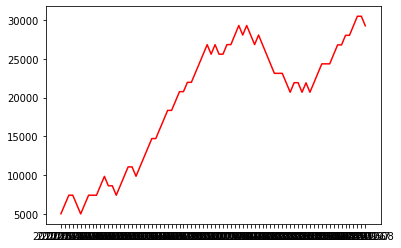

In [ ]:
plot_portfolio_results()

In [ ]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio, 
                    where sharpe ratio is defined as annualized return divided by annualized volatility 
                    
    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio
    
    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """
    
    annualized_return = 0.
    annualized_vol = 0.
    annualized_sharpe = 0.
    
    ### START CODE HERE ### (≈ 4-5 lines of code)
    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)) - 1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol
    ### END CODE HERE ###
    
    return annualized_return, annualized_vol, annualized_sharpe

The two baseline strategies we will compare against are momentum strategy with OLS and PCA eigen portfolio.

In [ ]:
def get_annualized_returns(returns_list):
  curr = 1
  newlist = []
  for ret in returns_list:
    curr = curr * (1+ret)
    newlist.append(curr)
  return newlist

In [ ]:
spy_ret = get_annualized_returns(ETF_Returns.loc["SPY Returns"])

NameError: ignored